In [21]:
import numpy as np
import pandas as pd
import os
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
path='../input/plant-pathology-2020-fgvc7/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

train_paths = train.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values
test_paths = test.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values

train_labels = train.loc[:, 'healthy':].values

In [5]:
print(train_labels)

[[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 ...
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [23]:
nb_classes = 4
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
img_size = 768
EPOCHS = 50
SEED = 123

In [46]:
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None, seed=2020):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    #image = tf.image.rot90(image, k=1)
    image = tf.image.transpose(image)

           
    if label is None:
        return image
    else:
        return image, label

In [47]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [48]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Learning rate schedule: 1e-05 to 0.0008 to 1.08e-05


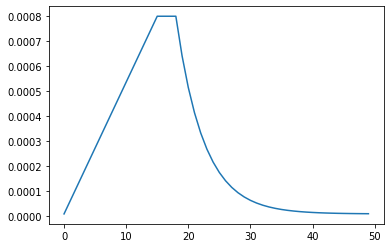

In [49]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [53]:
def get_model1():
    base_model =  efn.EfficientNetB7(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    #x = Dense(1200,activation='relu')(x)
    x = Dense(500,activation='relu')(x)
    x = Dense(250,activation='relu')(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [ ]:
with strategy.scope():
    model1 = get_model1()
    
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
%%time
history = model1.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

In [44]:
%%time

probs1 = model1.predict(test_dataset, verbose=1)


probs_1 = (probs1)
sub.loc[:, 'healthy':] = probs_1
sub.to_csv('submission_effnets4.csv', index=False)


29/29 [==============================] - 68s 2s/step
CPU times: user 9.68 s, sys: 249 ms, total: 9.93 s
Wall time: 1min 8s


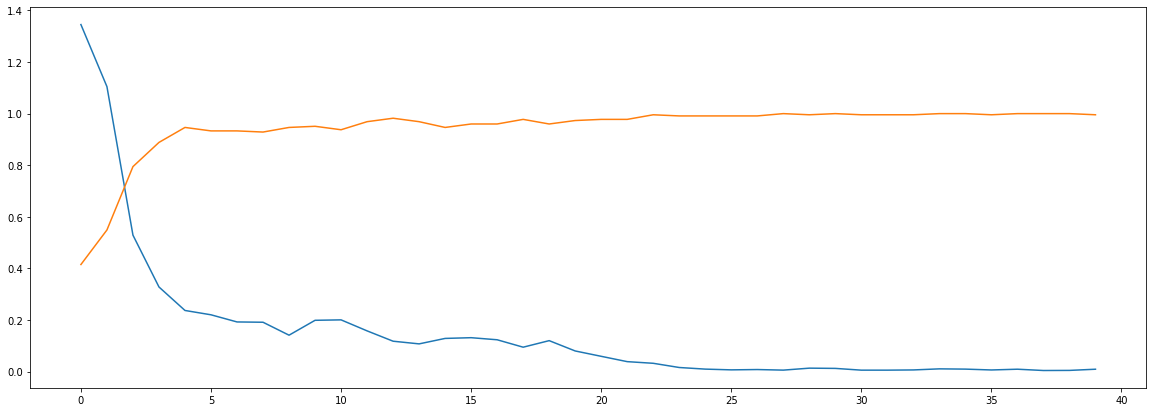

In [45]:
plt.figure(figsize=(20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['categorical_accuracy'])